In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def diffuse_agents(x, y, d, L):
    """
    Moves agents on the lattice based on diffusion probability.

    Parameters
    ----------
    x, y : Agents' positions.
    d : Diffusion probability.
    L : Side length of the lattice.

    Returns
    -------
    x, y : Updated positions.
    """
    N = np.size(x)
    diffuse = np.random.rand(N)
    move = np.random.randint(4, size=N)
    for i in range(N):
        if diffuse[i] < d:
            if move[i] == 0:
                x[i] = x[i] - 1
            elif move[i] == 1:
                y[i] = y[i] - 1
            elif move[i] == 2:
                x[i] = x[i] + 1
            else:
                y[i] = y[i] + 1

    # Enforce periodic boundary conditions.
    x = x % L
    y = y % L

    return x, y

In [3]:
def update_opinions(x, y, opinions, influencer_flags, media_flags, mu, attraction, deattraction, L, influence_radius, media_radius):
    """
    Updates agents' opinions based on interactions.

    Parameters
    ----------
    x, y : Agents' positions.
    opinions : Agents' opinions.
    influencer_flags : Boolean array indicating influencer agents.
    mu : Convergence parameter.
    attraction : Confidence bound.
    L : Side length of the lattice.
    influence_radius : Radius of influence for influencer agents.

    Returns
    -------
    opinions : Updated opinions.
    """
    N = np.size(x)
    # Create a grid to map agents to their positions for efficient lookup
    position_dict = {}
    for i in range(N):
        pos = (x[i], y[i])
        if pos in position_dict:
            position_dict[pos].append(i)
        else:
            position_dict[pos] = [i]

    # Interaction step
    for i in range(N):
        # Skip if influencer agent (they don't change their opinions)
        if influencer_flags[i]:
            continue

        # Agents in the same cell
        same_cell_agents = position_dict[(x[i], y[i])]
        for j in same_cell_agents:
            if i != j:
                # Check if opinions are within attraction
                if abs(opinions[i] - opinions[j]) < attraction:
                    # Update opinions towards each other
                    o_i = opinions[i]
                    o_j = opinions[j]
                    opinions[i] = o_i + mu * (o_j - o_i)
                if abs(opinions[i] - opinions[j]) > deattraction:
                    # Update opinions away from each other
                    o_i = opinions[i]
                    o_j = opinions[j]
                    opinions[i] = o_i - mu * (o_j - o_i)
                    # check if the opinion is within the bounds
                    if opinions[i] > 1:
                        opinions[i] = 1
                    elif opinions[i] < 0:
                        opinions[i] = 0
                    else:
                        pass

        # Influencer agents within influence radius
        for j in np.where(influencer_flags)[0]:
            # Calculate distance between agents considering periodic boundaries
            dx = min(abs(x[i] - x[j]), L - abs(x[i] - x[j]))
            dy = min(abs(y[i] - y[j]), L - abs(y[i] - y[j]))
            distance = np.sqrt(dx**2 + dy**2)

            if distance <= influence_radius:
                # Check if opinions are within attraction
                if abs(opinions[i] - opinions[j]) < attraction:
                    # Update opinion towards the influencer
                    o_i = opinions[i]
                    o_j = opinions[j]
                    opinions[i] = o_i + mu * (o_j - o_i)

                # Check if opinions are within attraction
                if abs(opinions[i] - opinions[j]) > deattraction:
                    # Update opinion away from the influencer
                    o_i = opinions[i]
                    o_j = opinions[j]
                    opinions[i] = o_i - mu * (o_j - o_i)
                    # check if the opinion is within the bounds
                    if opinions[i] > 1:
                        opinions[i] = 1
                    elif opinions[i] < 0:
                        opinions[i] = 0
                    else:
                        pass 
        
        # Media agents within media radius
        for j in np.where(media_flags)[0]:
            # Calculate distance between agents considering periodic boundaries
            dx = min(abs(x[i] - x[j]), L - abs(x[i] - x[j]))
            dy = min(abs(y[i] - y[j]), L - abs(y[i] - y[j]))
            distance = np.sqrt(dx**2 + dy**2)

            if distance <= media_radius:
                # Check if opinions are within attraction
                if abs(opinions[i] - opinions[j]) < attraction:
                    # Update opinion towards the media
                    o_i = opinions[i]
                    o_j = opinions[j]
                    opinions[i] = o_i + mu * (o_j - o_i)
                # Check if opinions are within attraction
                
                if abs(opinions[i] - opinions[j]) > deattraction:
                    # Update opinion away from the media
                    o_i = opinions[i]
                    o_j = opinions[j]
                    opinions[i] = o_i - mu * (o_j - o_i)
                    # check if the opinion is within the bounds
                    if opinions[i] > 1:
                        opinions[i] = 1
                    elif opinions[i] < 0:
                        opinions[i] = 0
                    else:
                        pass
                

    return opinions

In [4]:
def run_opinion_simulation(N_part, N_influencers, N_media, L, d, mu, attraction, deattraction, influence_radius, media_radius, max_steps):
    """
    Runs the opinion dynamics simulation.

    Parameters
    ----------
    N_part : Total number of agents (including influencers).
    N_influencers : Number of influencer agents.
    L : Side length of the lattice.
    d : Diffusion probability.
    mu : Convergence parameter.
    attraction : Confidence bound.
    influence_radius : Radius of influence for influencer agents.
    max_steps : Maximum number of time steps.

    Returns
    -------
    opinions_over_time : List of agents' opinions over time.
    """
    # Initialize agents' positions
    x = np.random.randint(L, size=N_part)
    y = np.random.randint(L, size=N_part)

    opinions = np.random.normal(0.5, 0.2, N_part)
    opinions = np.clip(opinions, 0, 1)

    # Generate a random permutation of indices
    indices = np.random.permutation(N_part)

    # Assign first N_influencers as influencers
    influencer_flags = np.zeros(N_part, dtype=bool)
    influencer_flags[indices[:N_influencers]] = True

    # Assign the next N_media as media agents
    media_flags = np.zeros(N_part, dtype=bool)
    media_flags[indices[N_influencers:N_influencers + N_media]] = True


    # Set media agents' opinions (e.g., neutral opinions)
    opinions[media_flags] = 0.1  # Media agents hold opinion 0.5 (neutral)
    # Alternatively, you can set different opinions for media agents
    # opinions[media_flags] = np.random.uniform(0.0, 1.0, N_media)


    # Set influencer agents' opinions (e.g., extreme opinions)
    opinions[influencer_flags] = 0.9  # Influencers hold opinion 0 (extremely left-leaning)
    # Alternatively, you can set different opinions for influencers
    # opinions[influencer_flags] = np.random.choice([0.0, 1.0], N_influencers)

    opinions_over_time = []
    for step in range(max_steps):
        # Diffusion step
        x, y = diffuse_agents(x, y, d, L)

        # Update opinions
        opinions = update_opinions(x, y, opinions, influencer_flags, media_flags, mu, attraction, deattraction, L, influence_radius, media_radius)

        opinions_over_time.append(opinions.copy())

        # Optional: Break if opinions have stabilized
        # Calculate opinion changes
        #if step > 0 and np.allclose(opinions_over_time[step], opinions_over_time[step - 1], atol=1e-4):
            #print(f"Opinions stabilized at step {step}.")
            #break

    return opinions_over_time, influencer_flags

In [5]:
def simulate_and_plot(N_part, N_influencers, N_media, L, d, mu, attraction, deattraction ,influence_radius, media_radius ,max_steps, num_runs, title):
    """
    Runs multiple simulations and plots the results.

    Parameters
    ----------
    N_part : Total number of agents (including influencers).
    N_influencers : Number of influencer agents.
    L : Side length of the lattice.
    d : Diffusion probability.
    mu : Convergence parameter.
    attraction : Confidence bound.
    influence_radius : Radius of influence for influencer agents.
    max_steps : Maximum number of time steps.
    num_runs : Number of independent runs.
    title : Title for the plots.
    """
    for run in range(num_runs):
        opinions_over_time, influencer_flags = run_opinion_simulation(
            N_part, N_influencers, N_media, L, d, mu, attraction, deattraction, influence_radius, media_radius, max_steps)

        # Plotting the opinion distributions at different time steps
        time_steps = [0,int(len(opinions_over_time)/4),int(len(opinions_over_time)/2), len(opinions_over_time)-1]
        for t in time_steps:
            plt.figure(figsize=(10, 6))
            plt.hist(opinions_over_time[t][~influencer_flags], bins=20, alpha=0.5, label=f'Time {t}')
            plt.xlabel('Opinion')
            plt.ylabel('Number of agents')
            plt.title(f'Run {run+1}: {title}')
            plt.legend()
            plt.show()


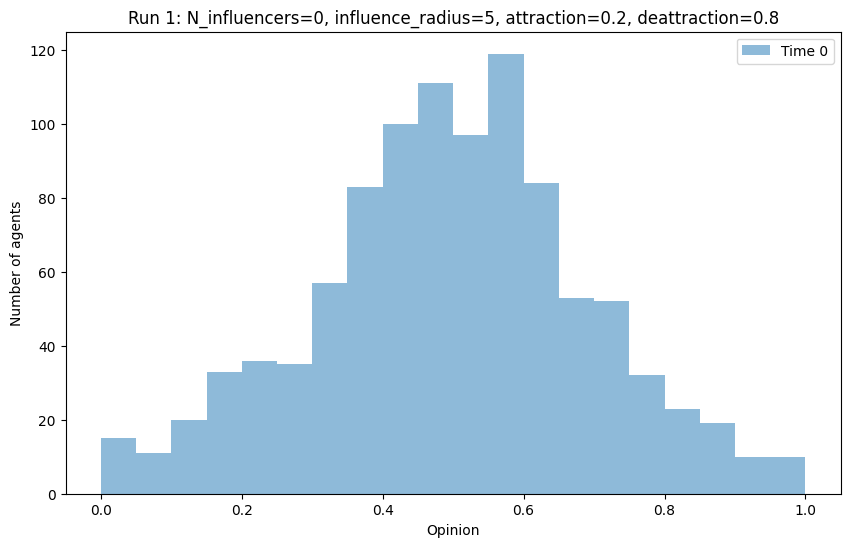

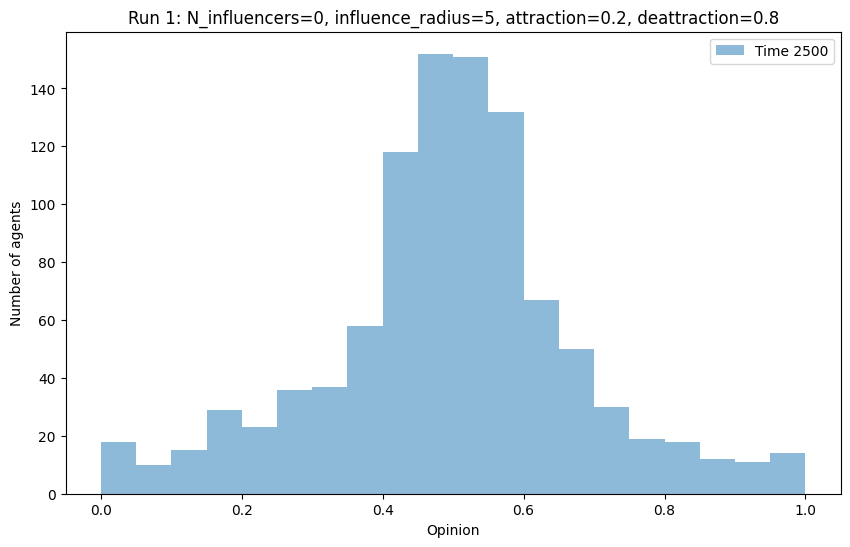

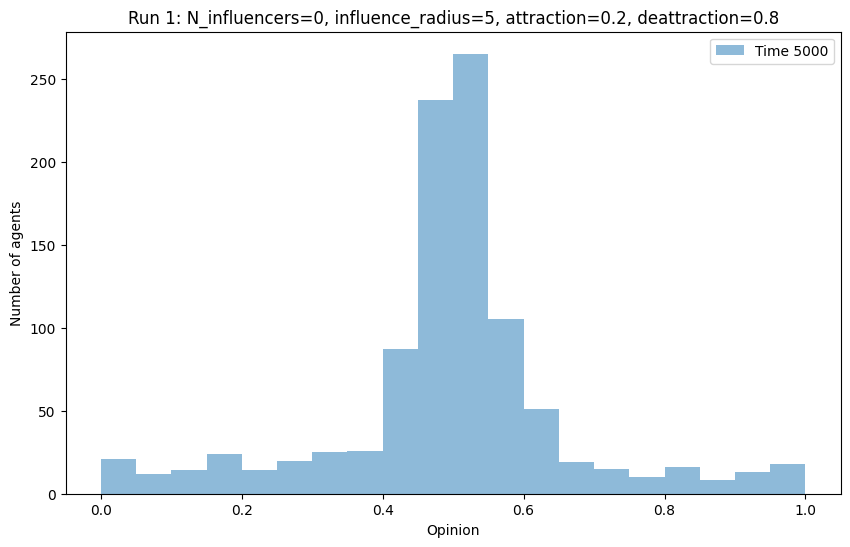

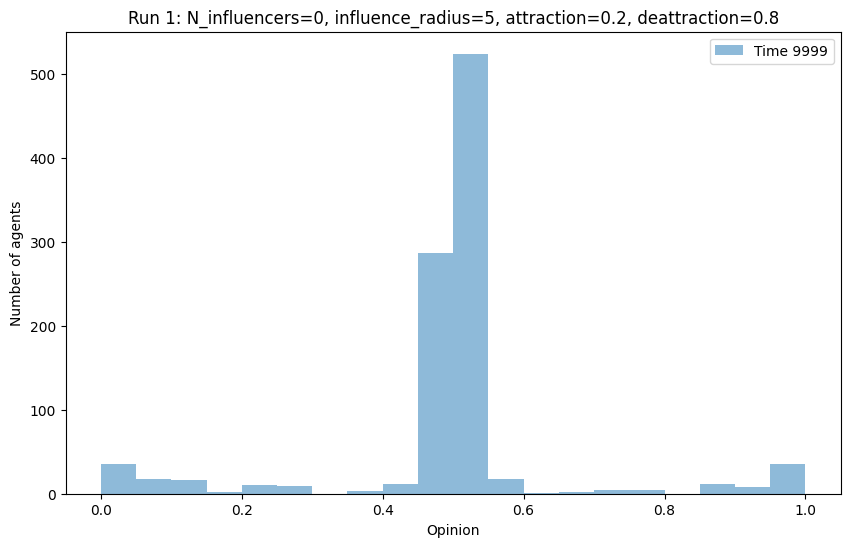

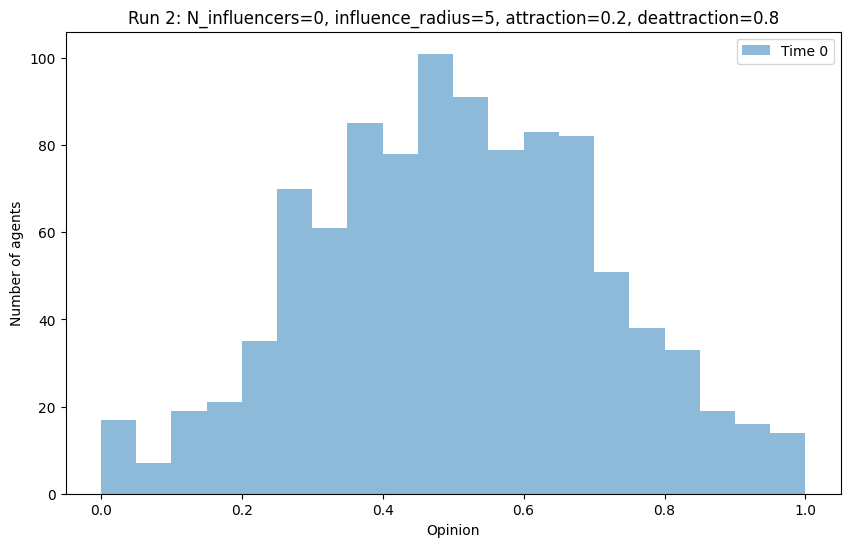

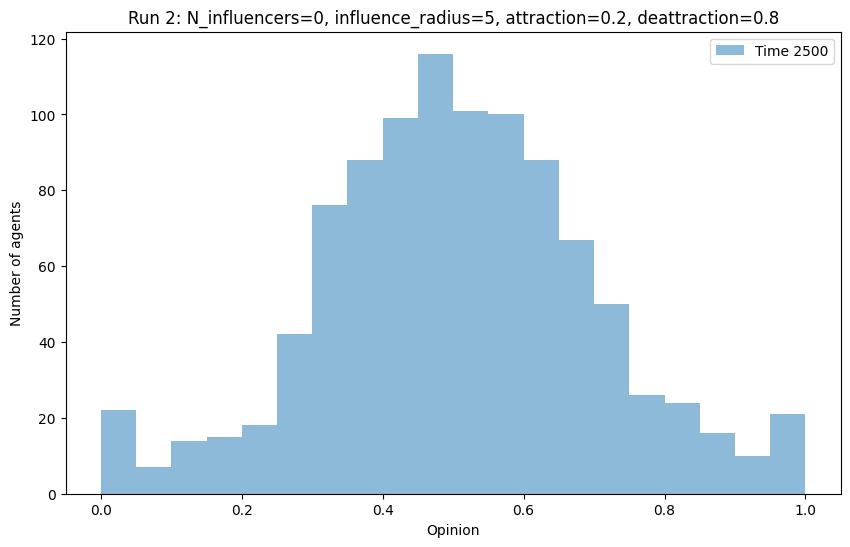

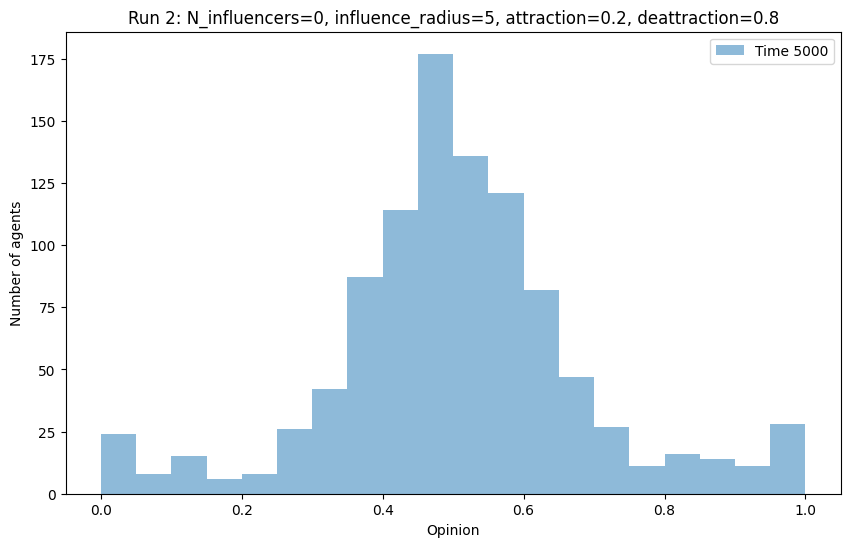

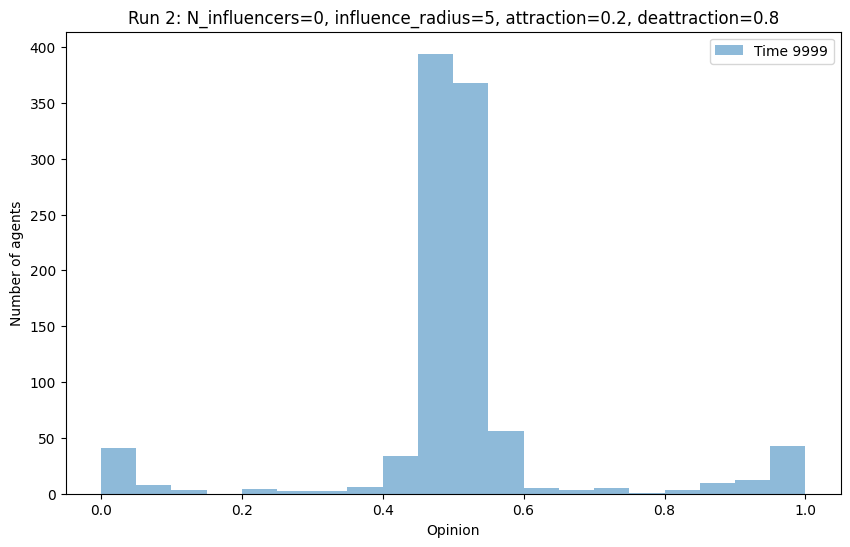

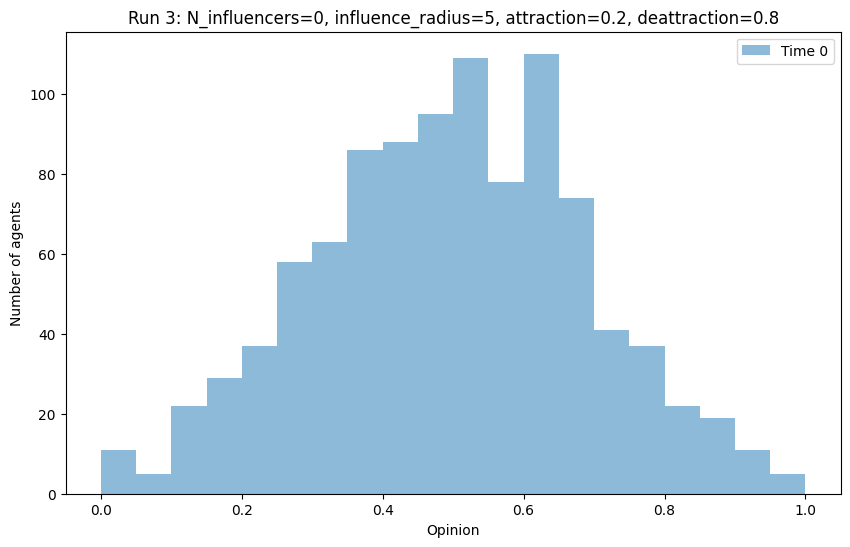

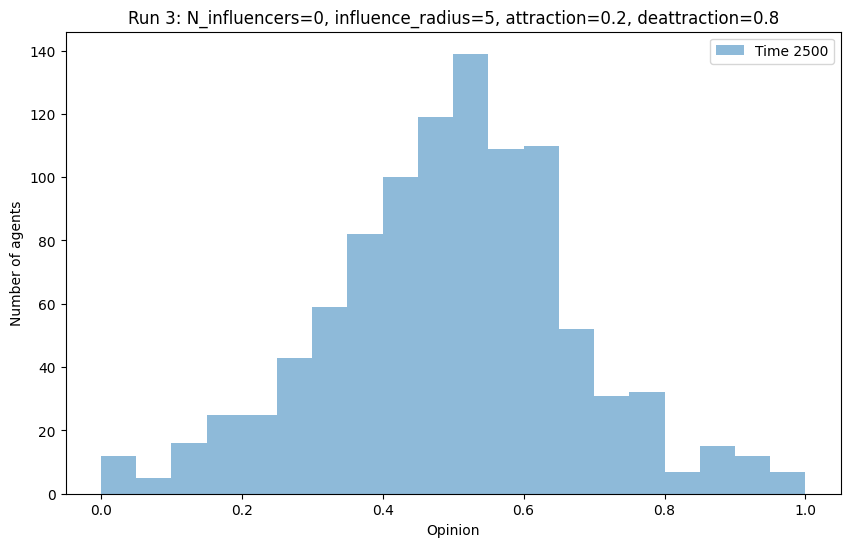

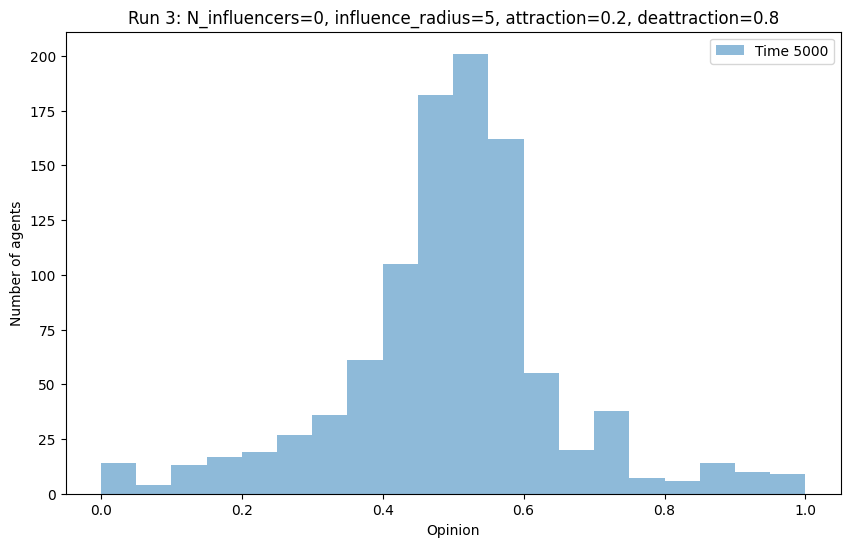

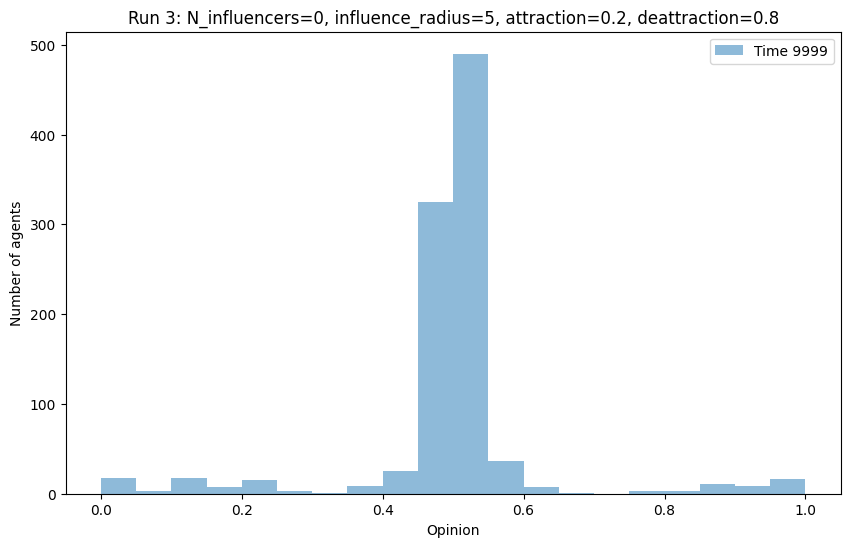

In [6]:
# Parameters
N_part = 1000        # Total number of agents (including influencers)
N_influencers = 0    # Number of influencer agents
N_media = 0          # Number of media agents
L = 50               # Side length of the lattice
d = 0.95             # Diffusion probability
mu = 0.001             # Convergence parameter
attraction = 0.2        # Confidence bound
deattraction = 0.8      # Deattraction bound
influence_radius = 5 # Influence radius for influencer agents
media_radius = 5     # Influence radius for media agents
max_steps = 10000     # Maximum number of time steps
num_runs = 3         # Number of independent runs

simulate_and_plot(
    N_part, N_influencers, N_media, L, d, mu, attraction, deattraction ,influence_radius, media_radius,max_steps, num_runs,
    title=f'N_influencers={N_influencers}, influence_radius={influence_radius}, attraction={attraction}, deattraction={deattraction}'
)